In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q


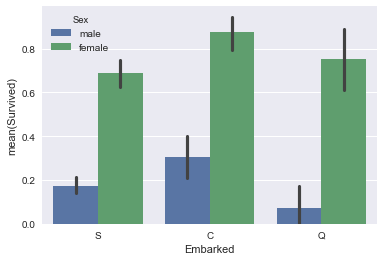

In [2]:
sns.barplot(x="Embarked" , y="Survived", hue = "Sex", data = data_train)

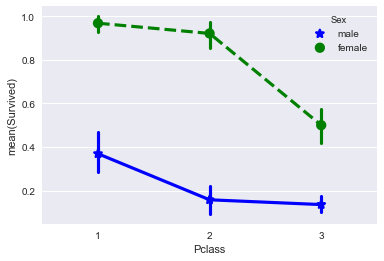

In [3]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
             palette={"male":"blue", "female":"green"},
             markers=["*","o"], linestyles=["-","--"])

In [4]:
data_train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1,0,5,12,18,25,35,60,120)
    group_names = ('Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior')
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ('Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile')
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_names(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_names(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


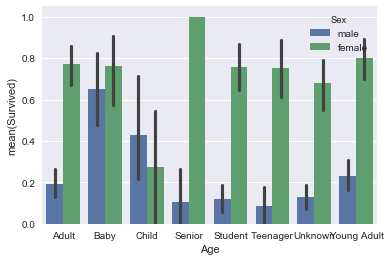

In [6]:
sns.barplot(x='Age', y='Survived', hue='Sex', data=data_train);

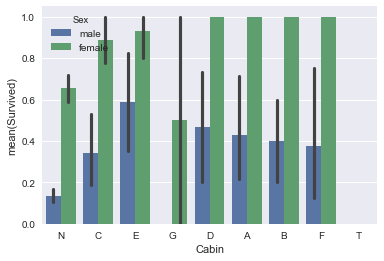

In [7]:
sns.barplot(x='Cabin', y='Survived', hue='Sex', data=data_train);

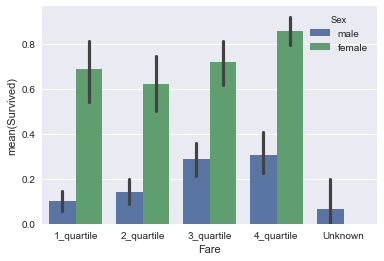

In [8]:
sns.barplot(x='Fare', y='Survived', hue='Sex', data=data_train);

In [9]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat((df_train[features], df_test[features]))
    
    for i in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[i])
        df_train[i] = le.transform(df_train[i])
        df_test[i] = le.transform(df_test[i])
    return df_train, df_test

data_train, data_test = encode_features(data_train,data_test)
data_train.head()
        

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [10]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis = 1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all, test_size=num_test, random_state=23)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

parameters = {'n_estimators': [4,6,9],
              'max_features': ['log2','sqrt','auto'],
               'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,5,10],
               'min_samples_split': [2,3,5],
               'min_samples_leaf': [1,5,8]}

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train,y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.849162011173


In [13]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

C:\Users\rupak\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fold 1 accuracy: 0.7888888888888889
Fold 2 accuracy: 0.8764044943820225
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.8426966292134831
Fold 6 accuracy: 0.8202247191011236
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.8314606741573034
Fold 9 accuracy: 0.8764044943820225
Fold 10 accuracy: 0.7865168539325843
Mean Accuracy: 0.8249563046192259


In [14]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
